In [42]:
import pickle
# ! pip install --user scikit-misc
import warnings
from datetime import datetime

import xgboost as xgb
from matplotlib.pyplot import title
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', )
warnings.simplefilter(action='ignore', )
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import maxfuse as mf
import anndata
import hdbscan
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, f1_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy import sparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_rows', 10)  # Display only 10 rows
pd.set_option('display.max_columns', 5)  # Display only 5 columns

# setup and load datasets (only run once)
## CODEX

In [12]:
codex = sc.read(filename="/home/barroz/projects/Columbia/STAT_ML_GEN/project/codex_codex_cn_tumor.h5ad")
# sc.pp.subsample(codex, fraction=0.03)
rna = sc.read(filename="/home/barroz/projects/Columbia/STAT_ML_GEN/project/scRNA-seq_rna_umap.h5ad")
# sc.pp.subsample(rna, fraction=0.3)


In [16]:
adata_obs = codex  #sc.read_h5ad('codex.h5ad').obs
adata_obs = codex.obs

adata_obs.head()

,orig.ident,nCount_CODEX,...,condition,neighborhood
2,Longitudinal_Analysis,5542.5302,...,CONTROL,2
4,Longitudinal_Analysis,5318.7952,...,CONTROL,2
5,Longitudinal_Analysis,4478.8312,...,CONTROL,2
6,Longitudinal_Analysis,17031.5743,...,CONTROL,2
7,Longitudinal_Analysis,6466.7471,...,CONTROL,2


In [17]:
# map neighborhood information (indices should match)
codex.obs['CN'] = adata_obs['neighborhood']

In [18]:
# FIX THIS
codex.obs['CN'] = codex.obs['CN'].replace({
    1: 'CN1 Tumor Boundary',
    2: 'CN2 Tumor Bulk',
    3: 'CN3 Neutrophils + Dead cells',
    4: 'CN4 CX3CR1+ Macrophage',
    5: 'CN5 Dead Cells Center',
    6: 'CN6 Lymphoid Rich',
    7: 'CN7 INOS+ and IFN-g Actv Macs',
}).astype('category')

In [19]:
rna.var['mf_features'] = \
sc.pp.highly_variable_genes(rna, n_top_genes=2000, batch_key=None, flavor='seurat_v3', layer='counts', inplace=False)[
    'highly_variable']

In [20]:
sc.tl.rank_genes_groups(rna, groupby='new_annotation', method='t-test')


In [21]:
print(np.sum(rna.var['mf_features']))
for ct in rna.obs['new_annotation'].unique():
    degs = sc.get.rank_genes_groups_df(rna, group=ct).iloc[:100, 0].values
    rna.var.loc[rna.var.index.isin(degs), 'mf_features'] = True
print(np.sum(rna.var['mf_features']))

2000
2380


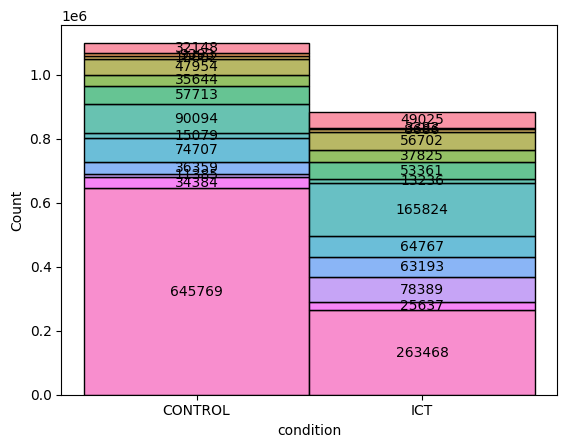

In [22]:
ax = sns.histplot(codex.obs, x='condition', hue='cell_type', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')

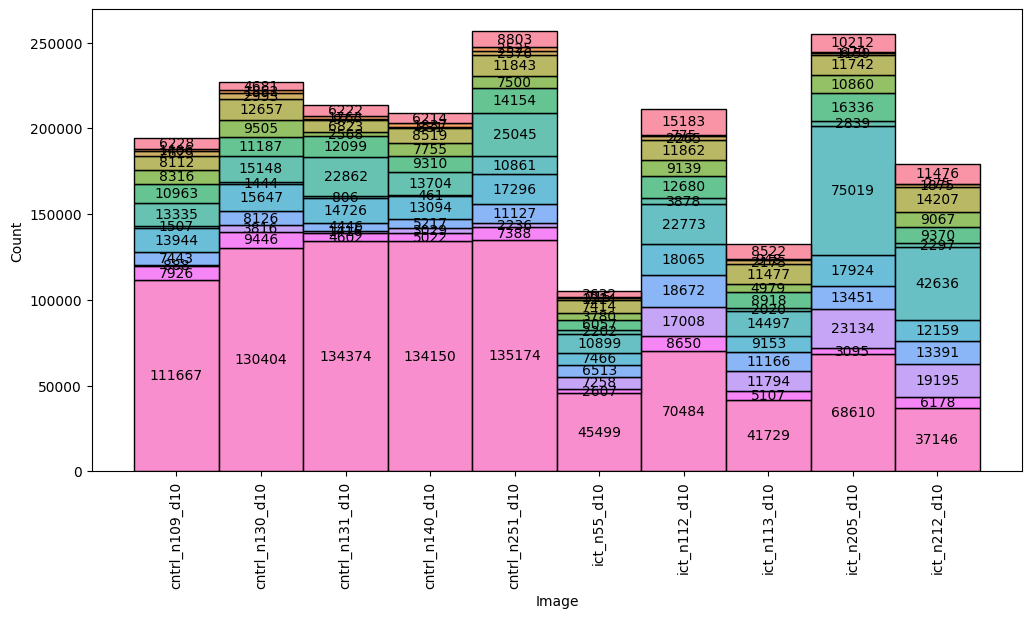

In [23]:
plt.subplots(figsize=(12, 6))
ax = sns.histplot(codex.obs, x='Image', hue='cell_type', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.xticks(rotation=90);

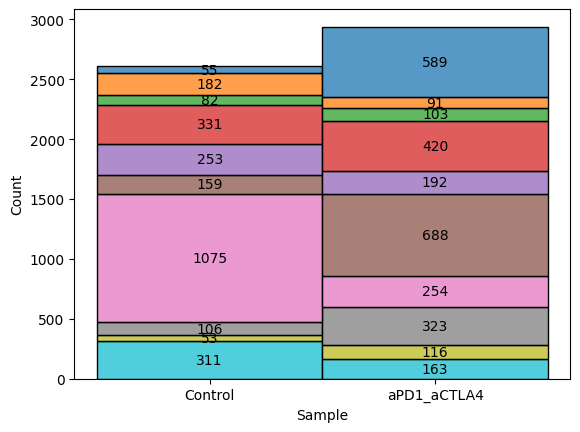

In [24]:
ax = sns.histplot(rna.obs, x='Sample', hue='new_annotation', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')

In [25]:
# from maxfuse repo
conversion = pd.read_csv('data/protein_gene_conversion.csv', index_col=0)


In [26]:
h_m_map = pd.read_csv('data/human2mouse.txt', sep='\t', index_col=0)
h_m_map.reset_index(inplace=True)

In [27]:
found_rna = []
not_found = []
for gene in codex.var_names:
    if gene.capitalize() in rna.var_names:
        found_rna.append(gene.capitalize())
    else:
        not_found.append(gene.capitalize())

In [28]:

found_h_m_map = []
for i, gene in enumerate(not_found):
    if gene.capitalize() in h_m_map['Mouse'].values:
        found_h_m_map.append(gene.capitalize())
        not_found.pop(i)

In [29]:
found_protein_conversion = []
for i, gene in enumerate(not_found):
    if gene in conversion.index.values:
        found_protein_conversion.append(gene + ':' + conversion.loc[gene, 'RNA name'])
        not_found.pop(i)

In [30]:
found_protein_conversion2 = []
for i, gene in enumerate(not_found):
    if gene.upper() in conversion.index.values:
        found_protein_conversion2.append(gene + ':' + conversion.loc[gene.upper(), 'RNA name'])
        not_found.pop(i)

In [31]:
print('found in rna:', found_rna)
print('needs human mapping:', found_h_m_map)
print('found_protein_conversion', found_protein_conversion)
print('found_protein_conversion2', found_protein_conversion2)
print(not_found)

found in rna: ['Foxp3', 'Cx3cr1', 'Xcr1', 'Gzmb', 'Cd4', 'Lag3', 'Cd38', 'Ly6g']
needs human mapping: []
found_protein_conversion ['Ki67:MKI67', 'Cd90:THY1']
found_protein_conversion2 ['Cd103:ITGAE', 'Cd3:CD3E/CD3D/CD3G', 'Pd1:PDCD1', 'Cd45:PTPRC/PTPRCAP', 'Cd31:PECAM1', 'Cd24:CD24', 'Pdl1:CD274']
['Cd140', 'Cd8', 'Nkp46', 'Tim 3', 'Sirp-alpha', 'Cd206', 'Caspase 3', 'Cd64', 'F4-80', 'Cd11c', 'Inos', 'Cd11b', 'Mhcii']


In [32]:
protein_mapping = {
    'cd103': 'Itgae',
    'ki67': 'Mki67',
    'foxp3': 'Foxp3',
    'cd140': 'Pdgfra',  # CD140 protein same as PDGFRA gene? 
    'cx3cr1': 'Cx3cr1',
    'cd3': 'Cd3d',  # or Cd3e or Cd3g 
    'cd8': 'Cd8b1',  # or Cd8a
    'nkp46': 'Ncr1',  # NKP46 protein same as NCR1 gene?
    'tim 3': 'Havcr2',  # TIM3 protein same as HAVCR2 gene?  
    'xcr1': 'Xcr1',
    'sirp-alpha': 'Sirpa',
    'gzmB': 'Gzmb',
    'pd1': 'Pdcd1',
    'cd206': 'Mrc1',
    'cd4': 'Cd4',
    'caspase 3': 'Casp3',
    'cd45': 'Ptprc',  # or Ptprcap
    'Lag3': 'Lag3',
    'cd64': 'Fcgr1',
    'f4-80': 'Adgre1',
    'cd38': 'Cd38',
    'cd31': 'Pecam1',
    'cd11c': 'Itgax',
    'cd24': 'Cd24a',
    'inos': 'Nos2',
    'cd11b': 'Itgam',
    'ly6G': 'Ly6g',
    'cd90': 'Thy1',
    'mhcii': None,
    # composed of HLA-DPA1, HLA-DPB1, HLA-DQA1, HLA-DQB1, HLA-DRA? # not including because biased towards treated condition in scRNA, vs. codex
    'pdL1': 'Cd274',
}

In [33]:
print(sorted(list(rna.var[rna.var_names.str.contains('H2')].index))[8:])

['H2-Aa', 'H2-Ab1', 'H2-D1', 'H2-DMa', 'H2-DMb1', 'H2-DMb2', 'H2-Eb1', 'H2-Eb2', 'H2-K1', 'H2-Ke6', 'H2-M2', 'H2-M3', 'H2-Oa', 'H2-Ob', 'H2-Q1', 'H2-Q10', 'H2-Q4', 'H2-Q6', 'H2-Q7', 'H2-T22', 'H2-T23', 'H2-T24', 'H2-T3', 'H2afj', 'H2afv', 'H2afx', 'H2afy', 'H2afy2', 'H2afz']


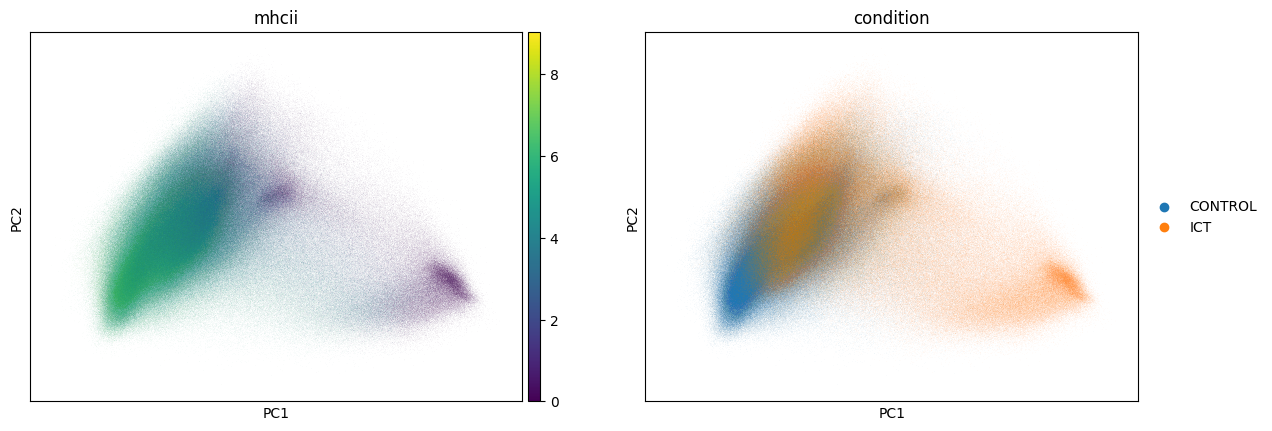

In [34]:
# run pca
sc.pp.pca(codex)
sc.pl.pca(codex, color=['mhcii', 'condition'])


In [35]:
protein_index = list()
RNA_index = list()
for protein in protein_mapping.keys():
    if protein_mapping[protein] != None:
        protein_index.append(protein)
        RNA_index.append(protein_mapping[protein])
print(protein_index)
print(RNA_index)

['cd103', 'ki67', 'foxp3', 'cd140', 'cx3cr1', 'cd3', 'cd8', 'nkp46', 'tim 3', 'xcr1', 'sirp-alpha', 'gzmB', 'pd1', 'cd206', 'cd4', 'caspase 3', 'cd45', 'Lag3', 'cd64', 'f4-80', 'cd38', 'cd31', 'cd11c', 'cd24', 'inos', 'cd11b', 'ly6G', 'cd90', 'pdL1']
['Itgae', 'Mki67', 'Foxp3', 'Pdgfra', 'Cx3cr1', 'Cd3d', 'Cd8b1', 'Ncr1', 'Havcr2', 'Xcr1', 'Sirpa', 'Gzmb', 'Pdcd1', 'Mrc1', 'Cd4', 'Casp3', 'Ptprc', 'Lag3', 'Fcgr1', 'Adgre1', 'Cd38', 'Pecam1', 'Itgax', 'Cd24a', 'Nos2', 'Itgam', 'Ly6g', 'Thy1', 'Cd274']


In [36]:
rna_shared = rna[:, RNA_index].copy()
codex_shared = codex[:, protein_index].copy()
print(rna_shared.shape)
print(codex_shared.shape)

(5546, 29)
(1984127, 29)


In [37]:
protein_index = list()
RNA_index = list()
for protein in protein_mapping.keys():
    if protein_mapping[protein] != None:
        protein_index.append(protein)
        RNA_index.append(protein_mapping[protein])
print(protein_index[:5], '...')
print(RNA_index[:5], '...')

['cd103', 'ki67', 'foxp3', 'cd140', 'cx3cr1'] ...
['Itgae', 'Mki67', 'Foxp3', 'Pdgfra', 'Cx3cr1'] ...


In [38]:
# only 18 of the ~30 shared features are HVGs in scRNA-seq
rna_shared = rna[:, RNA_index].copy()
codex_shared = codex[:, protein_index].copy()
print(rna_shared.shape)
print(codex_shared.shape)
np.sum(rna_shared.var['mf_features'])


(5546, 29)
(1984127, 29)


18

In [39]:
rna.var.loc[RNA_index, 'mf_features'] = True
rna_shared.var.loc[RNA_index, 'mf_features'] = True
print(np.sum(rna.var['mf_features']))

2391


In [40]:
sc.pp.neighbors(rna_shared, n_neighbors=15, use_rep='X')
sc.tl.umap(rna_shared)

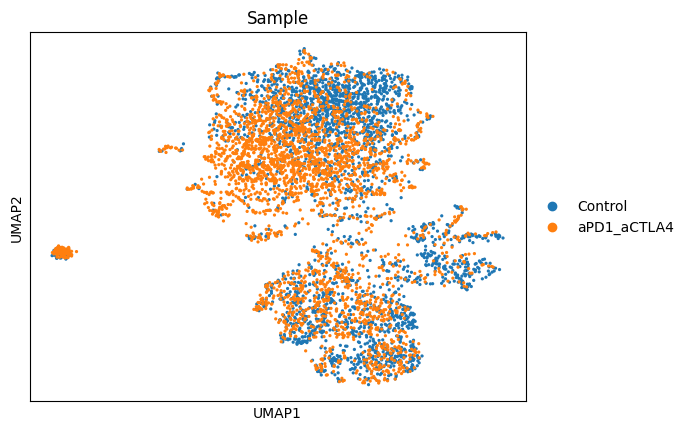

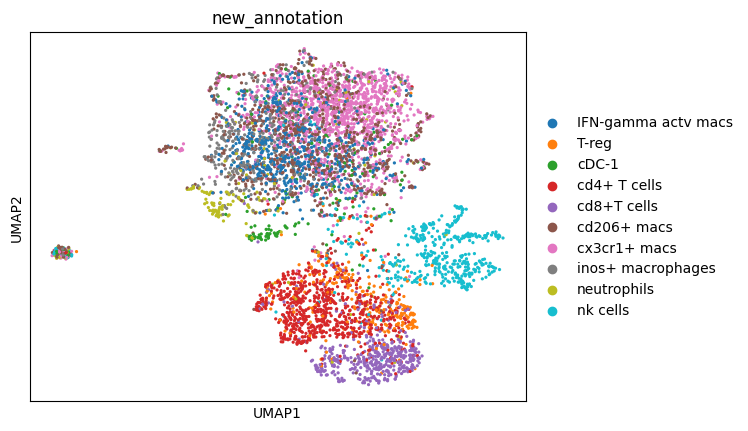

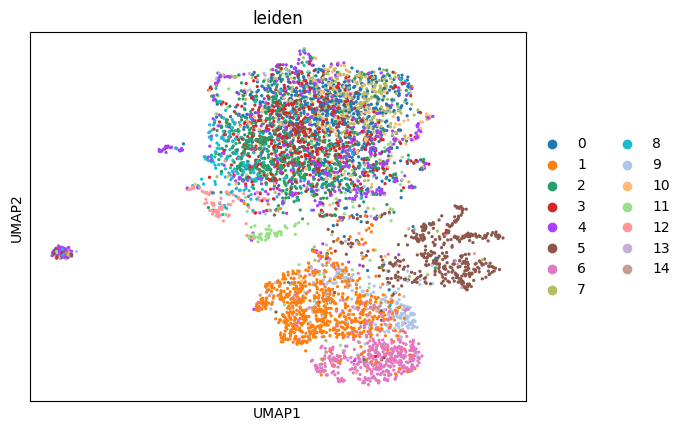

In [41]:
sc.pl.umap(rna_shared, color=['Sample'])
sc.pl.umap(rna_shared, color=['new_annotation'])
sc.pl.umap(rna_shared, color=['leiden'])

In [42]:
rna_shared = rna_shared.X.copy()
codex_shared = codex_shared.X.copy()

In [43]:
rna_active = rna[:, rna.var['mf_features']].copy()
sc.pp.scale(rna_active)  # preprocessing in the tutorial, makes it mean=0 and std var
rna_active = rna_active.X

In [44]:
codex_active = codex.copy()
# not sure if needed to scale protein measurements (they don't do it in tutorial, but the scale might be [0,1] based on methods section)
codex_active = codex.X

In [45]:
rna_active = np.asarray(rna_active)  # already dense numpy array
codex_active = np.asarray(codex_active.todense())
rna_shared = np.asarray(rna_shared.todense())
codex_shared = np.asarray(codex_shared.todense())

print(rna_active.shape)
print(codex_active.shape)
print(rna_shared.shape)
print(codex_shared.shape)

(5546, 2391)
(1984127, 30)
(5546, 29)
(1984127, 29)


# Fix MaxFuse

In [46]:
# use cell labels to guide MaxFuse smoothing steps
labels_rna = rna.obs['new_annotation'].values
labels_codex = codex.obs['cell_type'].values

display(labels_rna)
display(labels_codex)

['T-reg', 'cx3cr1+ macs', 'cx3cr1+ macs', 'cx3cr1+ macs', 'cx3cr1+ macs', ..., 'T-reg', 'cx3cr1+ macs', 'T-reg', 'T-reg', 'inos+ macrophages']
Length: 5546
Categories (10, object): ['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', ..., 'cx3cr1+ macs', 'inos+ macrophages', 'neutrophils', 'nk cells']

['cd4+ T cells', 'cd4+ T cells', 'cd4+ T cells', 'dead', 'cd4+ T cells', ..., 'tumor', 'tumor', 'nk cells', 'tumor', 'nk cells']
Length: 1984127
Categories (13, object): ['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', ..., 'inos+ macrophages', 'neutrophils', 'nk cells', 'tumor']

In [47]:
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    active_arr1=rna_active,
    labels1=labels_rna,
    shared_arr2=codex_shared,
    active_arr2=codex_active,
    labels2=labels_codex,
)

In [48]:
# see tutorial for explanation -- the below reduces computational complexity
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 5546, and max batch size is 5546.
The second data is split into 62 batches, average batch size is 32002, and max batch size is 32005.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4', '0<->5', '0<->6', '0<->7', '0<->8', '0<->9', '0<->10', '0<->11', '0<->12', '0<->13', '0<->14', '0<->15', '0<->16', '0<->17', '0<->18', '0<->19', '0<->20', '0<->21', '0<->22', '0<->23', '0<->24', '0<->25', '0<->26', '0<->27', '0<->28', '0<->29', '0<->30', '0<->31', '0<->32', '0<->33', '0<->34', '0<->35', '0<->36', '0<->37', '0<->38', '0<->39', '0<->40', '0<->41', '0<->42', '0<->43', '0<->44', '0<->45', '0<->46', '0<->47', '0<->48', '0<->49', '0<->50', '0<->51', '0<->52', '0<->53', '0<->54', '0<->55', '0<->56', '0<->57', '0<->58', '0<->59', '0<->60', '0<->61'].


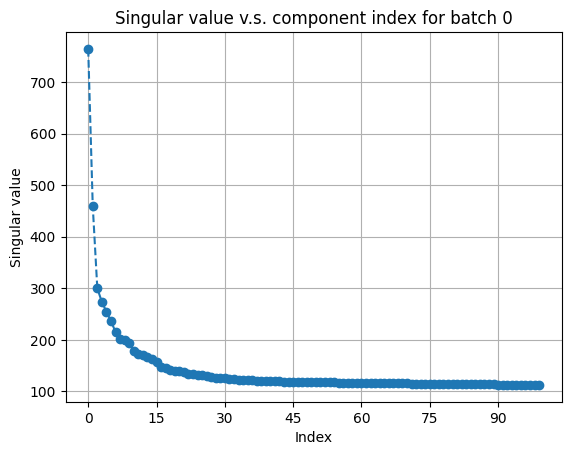

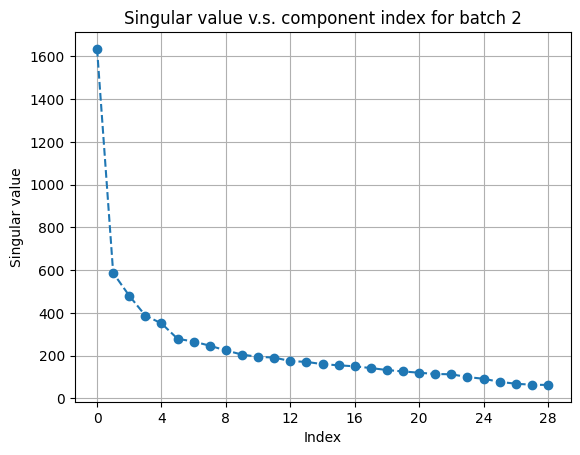

In [49]:
# plot top singular values of active_arr1 on a random batch
fusor.plot_singular_values(target='active_arr1',
                           n_components=None);  # can also explicitly specify the number of components
# plot top singular values of active_arr2 on a random batch
fusor.plot_singular_values(target='active_arr2', n_components=None);

In [50]:
svd_components1 = 40
svd_components2 = 15

fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=svd_components1,
    svd_components2=svd_components2,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!


In [51]:
svd_components1 = 20
svd_components2 = 20

fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    # weights of first and second modality; smaller = greater strength of fuzzy smoothing, 1 = original data used
    svd_components1=svd_components1, svd_components2=svd_components2)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Now at batch 0<->9...
Now at batch 0<->10...
Now at batch 0<->11...
Now at batch 0<->12...
Now at batch 0<->13...
Now at batch 0<->14...
Now at batch 0<->15...
Now at batch 0<->16...
Now at batch 0<->17...
Now at batch 0<->18...
Now at batch 0<->19...
Now at batch 0<->20...
Now at batch 0<->21...
Now at batch 0<->22...
Now at batch 0<->23...
Now at batch 0<->24...
Now at batch 0<->25...
Now at batch 0<->26...
Now at batch 0<->27...
Now at batch 0<->28...
Now at batch 0<->29...
Now at batch 0<->30...
Now at batch 0<->31...
Now at batch 0<->32...
Now at batch 0<->33...
Now at batch 0<->34...
Now at batch 0<->35...
Now at batch 0<->36...
Now at batch 0<->37...
Now at batch 0<->38...
Now at batch 0<->39...
Now at batch 0<->40...
Now at batch 0<->41...
Now at batch 0<->42...
Now at batch 0<->43..

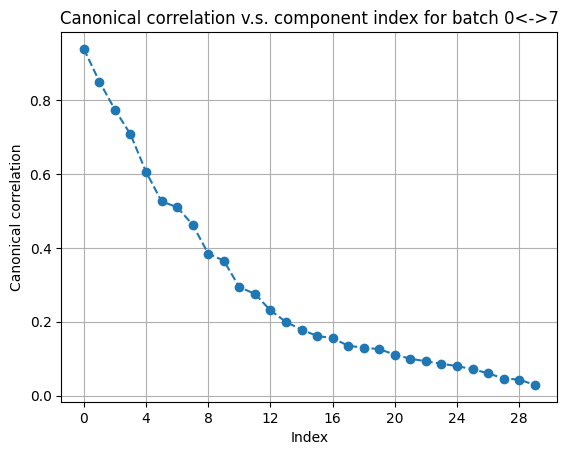

In [52]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=40,
    svd_components2=None,
    cca_components=30
);

In [53]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=None,
    cca_components=25,
    n_iters=1,
    randomized_svd=False,
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Now at batch 0<->9...
Now at batch 0<->10...
Now at batch 0<->11...
Now at batch 0<->12...
Now at batch 0<->13...
Now at batch 0<->14...
Now at batch 0<->15...
Now at batch 0<->16...
Now at batch 0<->17...
Now at batch 0<->18...
Now at batch 0<->19...
Now at batch 0<->20...
Now at batch 0<->21...
Now at batch 0<->22...
Now at batch 0<->23...
Now at batch 0<->24...
Now at batch 0<->25...
Now at batch 0<->26...
Now at batch 0<->27...
Now at batch 0<->28...
Now at batch 0<->29...
Now at batch 0<->30...
Now at batch 0<->31...
Now at batch 0<->32...
Now at batch 0<->33...
Now at batch 0<->34...
Now at batch 0<->35...
Now at batch 0<->36...
Now at batch 0<->37...
Now at batch 0<->38...
Now at batch 0<->39...
Now at batch 0<->40...
Now at batch 0<->41...
Now at batch 0<->42...
Now at batch 0<->43..

In [54]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.5)  # 50% recommended by tutorial for spatial data

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Now at batch 0<->9...
Now at batch 0<->10...
Now at batch 0<->11...
Now at batch 0<->12...
Now at batch 0<->13...
Now at batch 0<->14...
Now at batch 0<->15...
Now at batch 0<->16...
Now at batch 0<->17...
Now at batch 0<->18...
Now at batch 0<->19...
Now at batch 0<->20...
Now at batch 0<->21...
Now at batch 0<->22...
Now at batch 0<->23...
Now at batch 0<->24...
Now at batch 0<->25...
Now at batch 0<->26...
Now at batch 0<->27...
Now at batch 0<->28...
Now at batch 0<->29...
Now at batch 0<->30...
Now at batch 0<->31...
Now at batch 0<->32...
Now at batch 0<->33...
Now at batch 0<->34...
Now at batch 0<->35...
Now at batch 0<->36...
Now at batch 0<->37...
Now at batch 0<->38...
Now at batch 0<->39...
Now at batch 0<->40...
Now at batch 0<->41...
Now at batch 0<->42...
No

In [55]:
# check performance based on cell type accuracy (pivot matching)
pivot_matching = fusor.get_matching(order=(2, 1), target='pivot')

lv1_acc = mf.metrics.get_matching_acc(matching=pivot_matching,
                                      labels1=labels_rna,
                                      labels2=labels_codex,
                                      order=(2, 1)
                                      )
lv1_acc

0.8812485495474588

In [56]:
fusor.propagate(
    svd_components1=40,
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Now at batch 0<->9...
Now at batch 0<->10...
Now at batch 0<->11...
Now at batch 0<->12...
Now at batch 0<->13...
Now at batch 0<->14...
Now at batch 0<->15...
Now at batch 0<->16...
Now at batch 0<->17...
Now at batch 0<->18...
Now at batch 0<->19...
Now at batch 0<->20...
Now at batch 0<->21...
Now at batch 0<->22...
Now at batch 0<->23...
Now at batch 0<->24...
Now at batch 0<->25...
Now at batch 0<->26...
Now at batch 0<->27...
Now at batch 0<->28...
Now at batch 0<->29...
Now at batch 0<->30...
Now at batch 0<->31...
Now at batch 0<->32...
Now at batch 0<->33...
Now at batch 0<->34...
Now at batch 0<->35...
Now at batch 0<->36...
Now at batch 0<->37...
Now at batch 0<->38...
Now at batch 0<->39...
Now at batch 0<->40...
Now at batch 0<->41...
Now at batch 0<->42...
Now at batch 0<->43..

In [ ]:
fusor.filter_bad_matches(target='propagated', filter_prop=0.3)  # recommended filter_prop between 0.1 - 0.4

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...


In [ ]:
with open(f'fusor_object_{datetime.now().strftime("%Y-%m-%d_%H%M")}.pkl', 'wb') as f:
    pickle.dump(fusor, f)


In [ ]:
full_matching = fusor.get_matching(order=(2, 1),
                                   target='full_data')  # we want rna (1) to match with multiple codex (2), not other way around

In [ ]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])),
             columns=['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

In [ ]:
# compute the cell type level matching accuracy, for the full (filtered version) dataset
lv1_acc = mf.metrics.get_matching_acc(matching=full_matching,
                                      labels1=labels_rna,
                                      labels2=labels_codex
                                      )
lv1_acc

In [ ]:
cm = confusion_matrix(labels_rna[pivot_matching[0]], labels_codex[pivot_matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(labels_rna),
).plot()

In [ ]:
rna_embedding, codex_embedding = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)
codex.obsm['X_maxfuse'] = codex_embedding

codex_embedding = anndata.AnnData(codex_embedding)
codex_embedding.obs = codex.obs
rna_embedding = anndata.AnnData(rna_embedding)
rna_embedding.obs = rna.obs
codex_embedding.write('codex_embedding.h5ad')
rna_embedding.write('rna_embedding.h5ad')


In [3]:
# num rna cell vs num codex cell
codex_embedding = anndata.read('codex_embedding.h5ad')
rna_embedding = anndata.read('rna_embedding.h5ad')
print(rna_embedding.shape)
print(codex_embedding.shape)


(5546, 25)
(1984127, 25)


In [4]:

# Create an AnnData object combining RNA and CODEX cells in the shared space
rna_labels = ['RNA'] * rna_embedding.X.shape[0]
codex_labels = ['CODEX'] * codex_embedding.X.shape[0]
data_type_labels = np.concatenate([rna_labels, codex_labels])

combined_data = ad.AnnData(
    np.concatenate((rna_embedding.X, codex_embedding.X)),
    obs=pd.concat([rna.obs, codex.obs])
)
combined_data.obs['data_type'] = data_type_labels

# Perform UMAP on the combined data
# sc.pp.neighbors(combined_data, n_neighbors=15)
sc.tl.pca(combined_data)

# Plot the co-embedding
sample_fraction = 0.1
n_cells = combined_data.shape[0]
random_indices = np.random.choice(n_cells, size=int(n_cells * sample_fraction), replace=False)

# Subset the AnnData object to only include the sampled cells
sampled_data = combined_data[random_indices, :]
# sc.pl.pca(sampled_data, color=['Cluster', 'data_type'])



NameError: name 'rna' is not defined

# Train a classifier on the co-embedding

In [5]:
# prepare data for training
features = codex_embedding.X
labels = codex_embedding.obs['CN']
labels = labels.astype('category').values.codes

In [6]:

X = pd.DataFrame(features)
y = pd.DataFrame(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')
print(f'f1 score: {score:.4f}')

f1 score: 0.6553


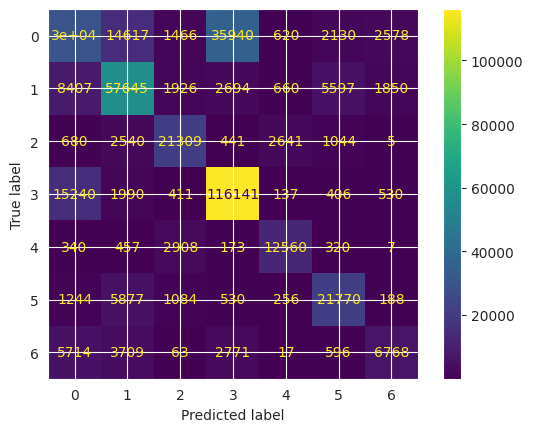

In [7]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Prepare the RNA features

In [8]:
# prepare data for training
features = rna_embedding.X
labels = None

In [9]:
predicted_RNA_CN = model.predict(features)

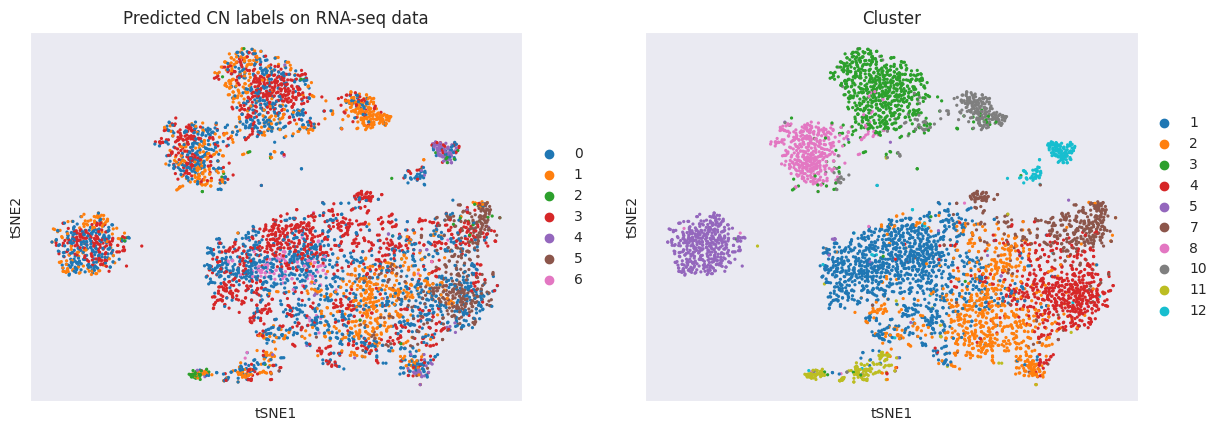

In [38]:
rna_embedding = anndata.AnnData(rna_embedding)
rna_embedding.obs = rna.obs
#  add the predicted CN labels to the RNA embedding
rna_embedding.obs['predicted_CN'] = pd.Categorical(predicted_RNA_CN)
# plot the RNA embedding with the predicted CN labels PCA
sc.tl.pca(rna_embedding)
# make the shape be the cell type
sc.pl.tsne(rna_embedding, color=['predicted_CN', 'Cluster'], title='Predicted CN labels on RNA-seq data')

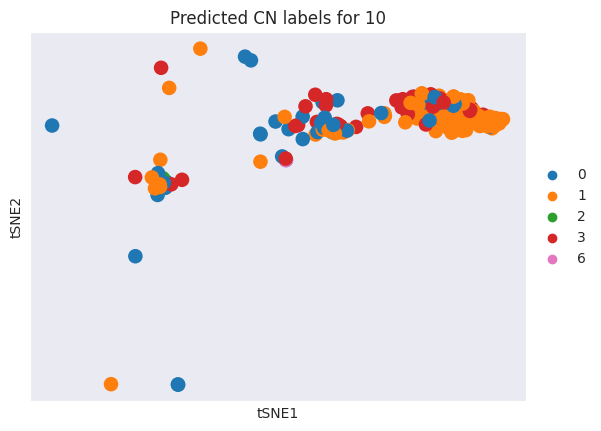

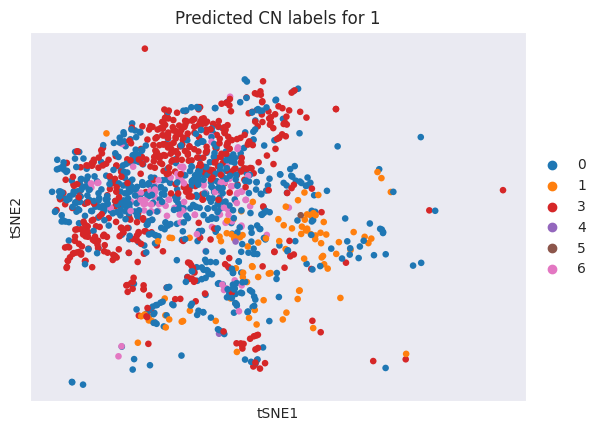

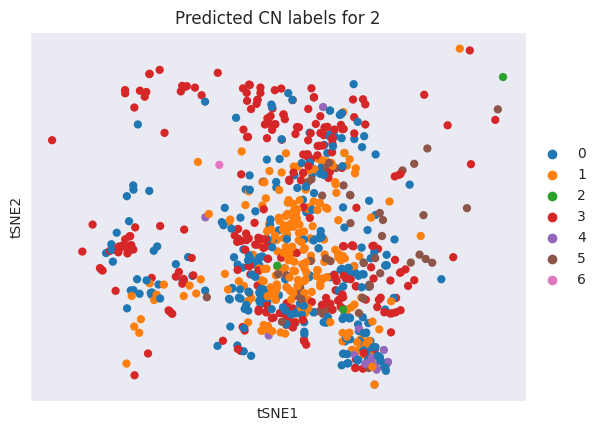

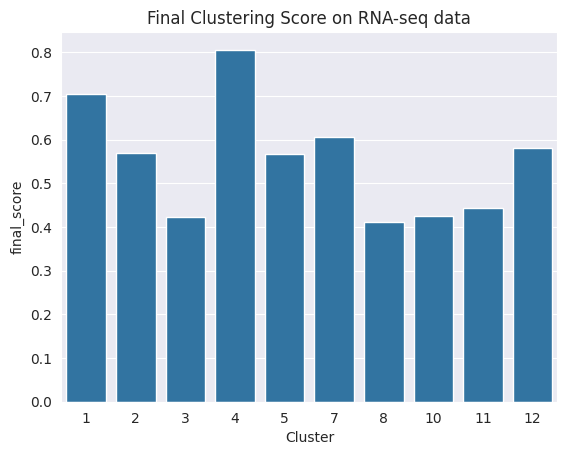

In [69]:
# 
cell_types = rna_embedding.obs['Cluster'].unique()
silhouette_score_per_cell_type = {}
davies_bouldin_score_per_cell_type = {}
calinski_harabasz_score_per_cell_type = {}
rna_embedding.obs['silhouette_score']  = [None]*rna_embedding.obs.shape[0]
rna_embedding.obs['davies_bouldin_score']  = [None]*rna_embedding.obs.shape[0]
rna_embedding.obs['calinski_harabasz_score']  = [None]*rna_embedding.obs.shape[0]
for curr_cell_type in cell_types:
    # get the scores for each cell type cluster
    curr_cell_type_indexes = rna_embedding.obs['Cluster'] == curr_cell_type
    curr_cell_type_data = rna_embedding[curr_cell_type_indexes].X
    curr_predicted_CN = rna_embedding.obs['predicted_CN'][curr_cell_type_indexes]
    
    silhouette_score_per_cell_type[curr_cell_type] = silhouette_score(curr_cell_type_data, curr_predicted_CN)
    davies_bouldin_score_per_cell_type[curr_cell_type] = -  davies_bouldin_score(curr_cell_type_data, curr_predicted_CN) # we want higer better
    calinski_harabasz_score_per_cell_type[curr_cell_type] = calinski_harabasz_score(curr_cell_type_data, curr_predicted_CN)
    
    rna_embedding.obs['silhouette_score'][curr_cell_type_indexes] = silhouette_score_per_cell_type[curr_cell_type]
    rna_embedding.obs['davies_bouldin_score'][curr_cell_type_indexes] = davies_bouldin_score_per_cell_type[curr_cell_type]
    rna_embedding.obs['calinski_harabasz_score'][curr_cell_type_indexes] = calinski_harabasz_score_per_cell_type[curr_cell_type]

# normalize all scores between 0 and 1 and means them to one final score using sklearn.preprocessing.MinMaxScaler:
scaler = MinMaxScaler()
rna_embedding.obs['norm_silhouette_score'] = scaler.fit_transform(rna_embedding.obs['silhouette_score'].values.reshape(-1, 1))
rna_embedding.obs['norm_davies_bouldin_score'] = scaler.fit_transform(rna_embedding.obs['davies_bouldin_score'].values.reshape(-1, 1))
rna_embedding.obs['norm_calinski_harabasz_score'] = scaler.fit_transform(rna_embedding.obs['calinski_harabasz_score'].values.reshape(-1, 1))
 
# mean all score to final score
rna_embedding.obs['final_score'] = (rna_embedding.obs['norm_silhouette_score'] + rna_embedding.obs['norm_davies_bouldin_score'] + rna_embedding.obs['norm_calinski_harabasz_score'])/3
sns.barplot(x='Cluster', y='final_score', data=rna_embedding.obs)
plt.title('Final Clustering Score on RNA-seq data')
plt.show()



KeyboardInterrupt: 

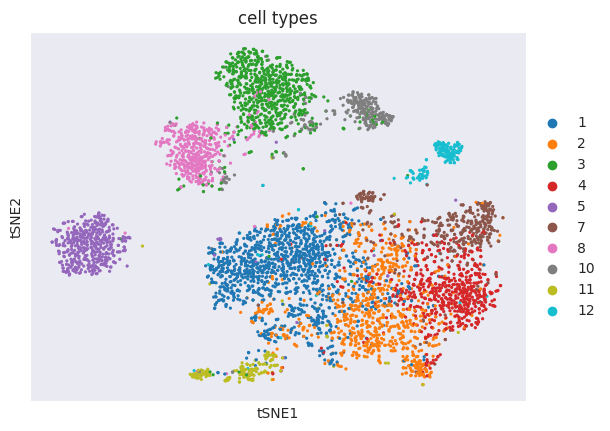

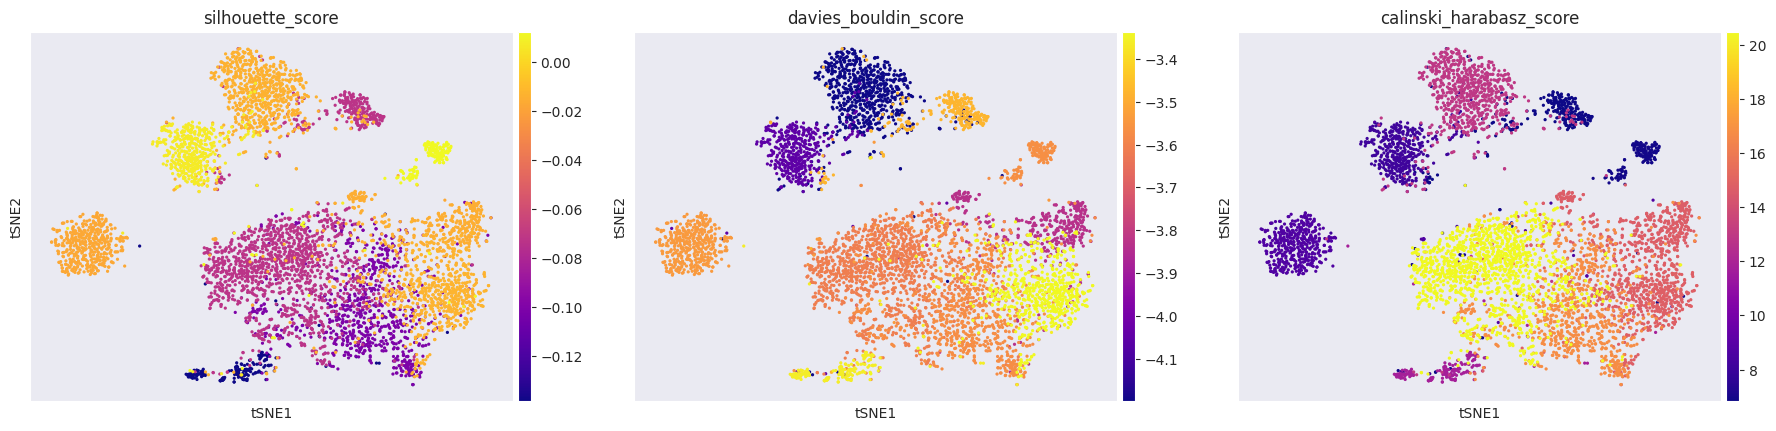

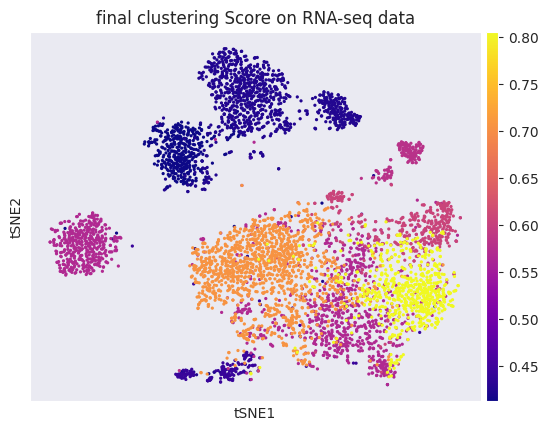

In [68]:
# plot the RNA embedding with the silhouette score as color with jet cmap
sc.pl.tsne(rna_embedding, color='Cluster', title='cell types')
sc.pl.tsne(rna_embedding, cmap='plasma',color=['silhouette_score','davies_bouldin_score','calinski_harabasz_score'])
sc.pl.tsne(rna_embedding, cmap='plasma',color=['final_score'], title='final clustering Score on RNA-seq data')
# merge all score to one when higher means better so I will have to max(davies_bouldin_score) - davies_bouldin_score and normalize all scores
    
    


array([8, 2, 1, 0, 7, 5, 6, 4, 3, 9])

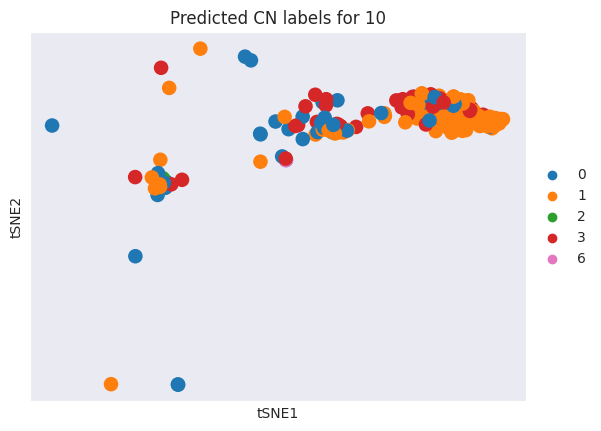

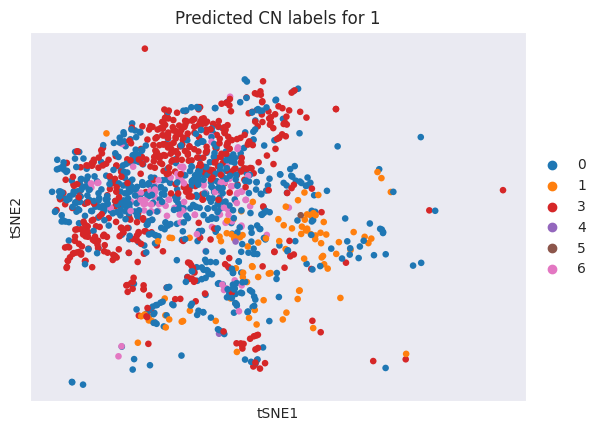

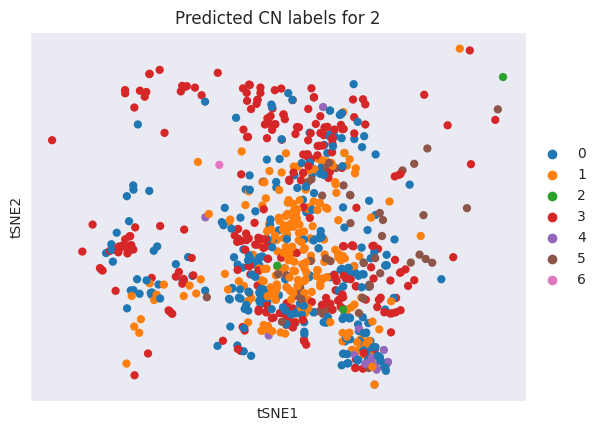

In [52]:
best_sil_score_cell_types_index = np.argsort(list(silhouette_score_per_cell_type.values()))

truncated_cell_types = rna_embedding.obs['Cluster'].unique()[:3]
# take the best 3 cell types
np.argmax(silhouette_score_per_cell_type)
for curr_cell_type in truncated_cell_types:
    subset_data = rna_embedding[rna_embedding.obs['Cluster'] == curr_cell_type]
    sc.pl.tsne(subset_data, color='predicted_CN', title=f'Predicted CN labels for {curr_cell_type}')

In [78]:
num_clusters = len(np.unique(codex_embedding.obs['CN']))
gmm = GaussianMixture(n_components=num_clusters, random_state=0)
gmm_labels = gmm.fit_predict(rna_embedding.X)
ami_score = adjusted_mutual_info_score(rna_embedding.obs['predicted_CN'], gmm_labels)
rna_embedding.obs['GMM'] = pd.Categorical(gmm_labels)
print('Adjusted Mutual Information Score:', ami_score)

Adjusted Mutual Information Score: 0.13153399921269995


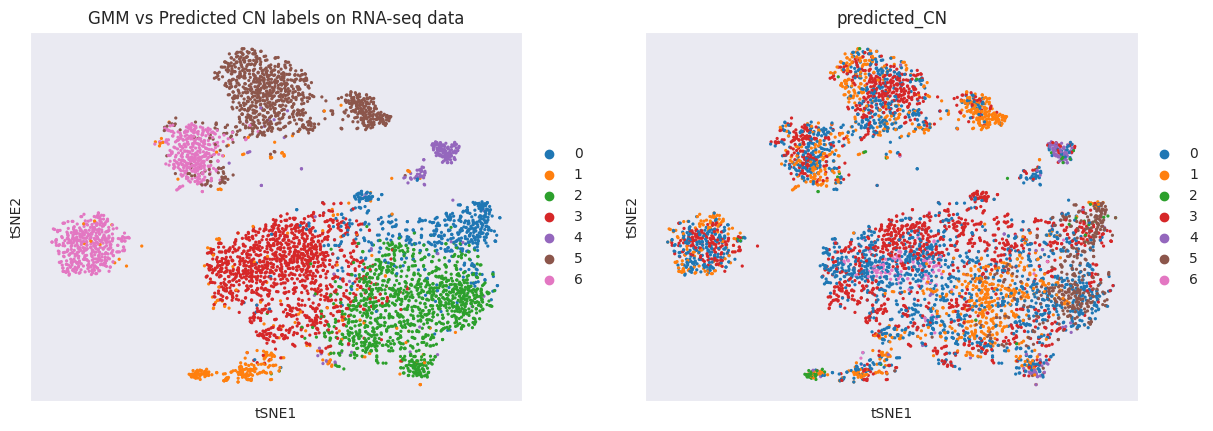

In [81]:
# plot the RNA embedding with the HDBSCAN labels vs the predicted CN labels
sc.pl.tsne(rna_embedding, color=['GMM', 'predicted_CN'], title='GMM vs Predicted CN labels on RNA-seq data')

In [80]:

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(rna_embedding.X)
hierarchy = clusterer.single_linkage_tree_.to_numpy()
num_clusters = len(np.unique(codex_embedding.obs['CN']))
selected_clusters = cut_tree(hierarchy, n_clusters=num_clusters).flatten()
rna_embedding.obs['HDBSCAN_Cut'] = pd.Categorical(selected_clusters)
# Check mutual information score between predicted CN labels and the cut HDBSCAN labels
ami_score = adjusted_mutual_info_score(rna_embedding.obs['predicted_CN'], rna_embedding.obs['HDBSCAN_Cut'])
print('Adjusted Mutual Information Score:', ami_score)

Adjusted Mutual Information Score: -0.0003301123280076968


In [ ]:
# plot the RNA embedding with the HDBSCAN labels vs the predicted CN labels
sc.pl.pca(rna_embedding, color=['HDBSCAN_Cut', 'predicted_CN'], title='HDBSCAN vs Predicted CN labels on RNA-seq data')